In [1]:
import sys
sys.path.insert(0, './src')

import random

import numpy
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from config import Config
from data import *
from models import *
from train import *
from run import setup_seed

In [2]:
setup_seed(12)

In [3]:
DATA_PATH = "./data/PSI_Biology_solubility_trainset.csv"
SAVE_MODEL_DIR = "./models/"
SAVE_MODEL_PREFIX = "cnn_"
LOAD_MODEL_PATH = None  # E.g. "./models/cnn_1"

In [4]:
config = Config.params

model_conf = {
        "embed": [20, 2],
        "cnn": [
            # in_channels, out_channels, kernel_size, dropout_p
            [2, 2, 3, 0.2],
            [2, 2, 3, 0.2],
        ],
        "linear": [
            # in_features, #out_features, dropout_p
            [config["max_chain_length"] * 2, config["max_chain_length"], 0.2],
        ],
    }

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
data = init_data(DATA_PATH, device, config["max_chain_length"])

In [7]:
model = Model3(model_conf)
model.to(device)

Model3(
  (embed): EmbedLayer(
    (linear): Linear(in_features=20, out_features=2, bias=True)
  )
  (cnn): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=1572, out_features=786, bias=True)
      (bn): BatchNorm1d(786, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (fc): Linear(in_features=786, o

In [8]:
# Load pretrained weights
if LOAD_MODEL_PATH != None:
    model.load_state_dict(torch.load(LOAD_MODEL_PATH))

In [9]:
optimiser = torch.optim.AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"],
)

In [10]:
criterion = nn.BCEWithLogitsLoss(pos_weight=data["neg_pos_ratio"]).to(device)

In [11]:
# Training
for e in range(1, 101):
    train_epoch(data, model, optimiser, criterion, config["batch_size"])

    # Evaluation
    if e % config["eval_step"] == 0:
        eval_model(e, data, model, optimiser, criterion)

        model.train()
        torch.save(model.state_dict(), SAVE_MODEL_DIR + SAVE_MODEL_PREFIX + str(e))

Epoch 10 - Train loss: 0.326; Test loss: 0.461
Accuracy: 0.648
Precision: 0.694
Recall: 0.762
Pred. STD: 0.245
F1: 0.719
ROC AUC: 0.676
Epoch 20 - Train loss: 0.235; Test loss: 0.673
Accuracy: 0.676
Precision: 0.849
Recall: 0.709
Pred. STD: 0.274
F1: 0.780
ROC AUC: 0.675
Epoch 30 - Train loss: 0.125; Test loss: 0.668
Accuracy: 0.662
Precision: 0.759
Recall: 0.738
Pred. STD: 0.327
F1: 0.748
ROC AUC: 0.661
Epoch 40 - Train loss: 0.094; Test loss: 0.718
Accuracy: 0.647
Precision: 0.757
Recall: 0.730
Pred. STD: 0.330
F1: 0.735
ROC AUC: 0.645
Epoch 50 - Train loss: 0.494; Test loss: 1.734
Accuracy: 0.683
Precision: 0.934
Recall: 0.685
Pred. STD: 0.214
F1: 0.801
ROC AUC: 0.676
Epoch 60 - Train loss: 0.203; Test loss: 1.273
Accuracy: 0.684
Precision: 0.883
Recall: 0.700
Pred. STD: 0.287
F1: 0.793
ROC AUC: 0.656
Epoch 70 - Train loss: 0.089; Test loss: 1.090
Accuracy: 0.667
Precision: 0.843
Recall: 0.706
Pred. STD: 0.323
F1: 0.772
ROC AUC: 0.626
Epoch 80 - Train loss: 0.083; Test loss: 1.021
A

In [12]:
model.eval()

Model3(
  (embed): EmbedLayer(
    (linear): Linear(in_features=20, out_features=2, bias=True)
  )
  (cnn): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=1572, out_features=786, bias=True)
      (bn): BatchNorm1d(786, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (fc): Linear(in_features=786, o

In [13]:
test_in = torch.eye(20).to(device)

In [14]:
output = model.embed.linear(test_in).cpu().detach().numpy()
output

array([[ 0.18382113,  0.03443246],
       [-0.3416912 , -0.45901734],
       [ 0.11369545, -0.07964338],
       [ 0.28270525,  0.13470906],
       [-0.13041915, -0.06921194],
       [ 0.0491766 , -0.07865518],
       [ 0.01770797, -0.25445247],
       [-0.03819498, -0.02200445],
       [ 0.29470757,  0.07730439],
       [-0.03931428, -0.01526424],
       [-0.08606548, -0.13247278],
       [ 0.16098498,  0.18817385],
       [ 0.09701578, -0.12452238],
       [ 0.1280261 , -0.28080624],
       [ 0.03851844, -0.17563023],
       [-0.07549916, -0.21412133],
       [ 0.5126911 , -0.10884296],
       [ 0.14292191, -0.10437769],
       [-0.06400001, -0.2262978 ],
       [-0.09022214,  0.02811728]], dtype=float32)

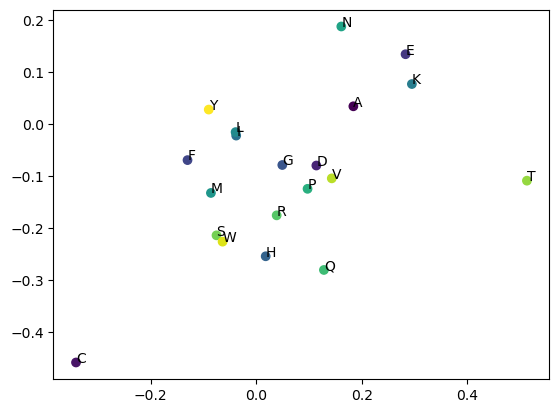

In [15]:
plt.scatter(output[:, 0], output[:, 1], c = range(20))
for i in range(20):
    plt.annotate(residues[i], (output[i, 0], output[i, 1]))